In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver
from PDE_solver_backend_laplace import PDESolverLaplace
from random import shuffle

In [227]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def make_points_line(N,which_axis,fixed_value,range_other,nugget=1e-5):
    assert which_axis in {'x','y'}
    X=np.zeros((N,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=fixed_value
    X[:,1-num_axis]=np.linspace(range_other[0]+nugget,range_other[1]-nugget,N)
    return X

def make_points_on_specific_boundary(Nb,which_axis,which_side,range_model=np.array([-1,1])):
    assert which_axis in {'x','y'}
    assert which_side in {-1,1}
    assert range_model.shape==(2,) and range_model[1]-range_model[0]>=0
    X=np.zeros((Nb,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=which_side
    X[:,1-num_axis]=np.random.rand(Nb)*(range_model[1]-range_model[0])+range_model[0]
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

def laplacian_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model.laplacian(x[which_model==i])
    return res



In [228]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=exp(-x+y)*cos(pi*x*y)#cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)#+u_symbolic**3
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
#tau=lambda x:np.power(x,3)
#dtau=lambda x:3*x**2
tau=lambda x:np.zeros_like(x)
dtau=lambda x:np.zeros_like(x)
f_symbolic

-(-pi**2*x**2*cos(pi*x*y) - 2*pi*x*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) - (-pi**2*y**2*cos(pi*x*y) + 2*pi*y*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y)

In [244]:
dxu_tuple=lambdify((x,y),diff(u_symbolic,x))
dxu=lambda xy:dxu_tuple(xy[0],xy[1])
dyu_tuple=lambdify((x,y),diff(u_symbolic,y))
dyu=lambda xy:dyu_tuple(xy[0],xy[1])


In [229]:
u_symbolic

exp(-x + y)*cos(pi*x*y)

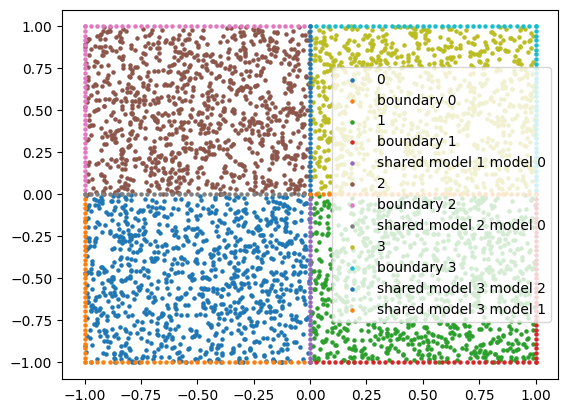

In [400]:
int_point_number=4000
ext_point_number=600
width=2
int_point_per_model=int_point_number//width**2
ext_point_per_model=ext_point_number//width**2

sigma=0.1
boundary_width=0

models=[]
laplace_models=[]
for i in range(width**2):

    ext_point_per_model=ext_point_number//width**2
    yi=i//width
    xi=i%width
    range_model=np.array([
        [-1+2*xi/width,-1+2*(xi+1)/width],
        [-1+2*yi/width,-1+2*(yi+1)/width]
    ])
    X_int=make_points_inside(int_point_per_model,range_model)
    X_bounds=[]
    if i%width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',-1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i%width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i//width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',-1,[-1+2*xi/width,-1+2*(xi+1)/width]))
    if i//width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',1,[-1+2*xi/width,-1+2*(xi+1)/width]))

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)

    try:
        X_boundary=np.concatenate(X_bounds)
        plt.scatter(X_boundary[:,0],X_boundary[:,1],label=f'boundary {i}',s=5)
    except ValueError:
        X_boundary=np.empty((0,2))
    
    models.append(
        PDESolver(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model {i}')
    )
    laplace_models.append(
        PDESolverLaplace(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model laplace {i}')
    )
    #ext_point_per_model=4#*np.random.randint(1,20)
    if i%width>0:
        range_neighbors=np.array([
            [-1+2*xi/width-boundary_width,-1+2*xi/width+boundary_width],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        #X_shared=make_points_line(ext_point_per_model//4,'x',-1+2*xi/width,[-1+2*yi/width,-1+2*(yi+1)/width])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        X_shared[:,1]=np.linspace(range_neighbors[1,0],range_neighbors[1,1],ext_point_per_model//4)
        models[-1].add_neighbors([models[-2]], [X_shared])
        models[-2].add_neighbors([models[-1]], [X_shared])
        laplace_models[-1].add_neighbors([laplace_models[-2]], [X_shared])
        laplace_models[-2].add_neighbors([laplace_models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        range_neighbors=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1+2*yi/width-boundary_width,-1+2*(yi)/width+boundary_width]
        ])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        #X_shared=make_points_line(ext_point_per_model//4,'y',-1+2*yi/width,[-1+2*xi/width,-1+2*(xi+1)/width])
        X_shared[:,0]=np.linspace(range_neighbors[0,0],range_neighbors[0,1],ext_point_per_model//4)
        models[-1].add_neighbors([models[-1-width]], [X_shared])
        models[-1-width].add_neighbors([models[-1]], [X_shared])
        laplace_models[-1].add_neighbors([laplace_models[-1-width]], [X_shared])
        laplace_models[-1-width].add_neighbors([laplace_models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.legend()
plt.show()

In [401]:
mat_left,target,pairs = PDESolverLaplace.joint_fit(laplace_models,f,real_u)
local_aggregate=partial(dumb_aggregate,models=laplace_models,width=width)

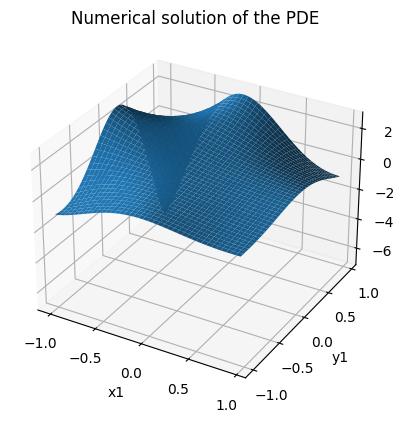

In [419]:
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

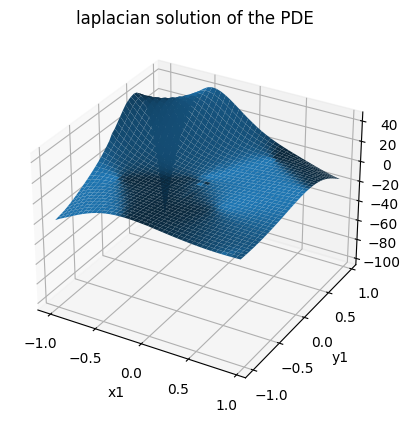

In [422]:
local_laplacian=partial(laplacian_aggregate,models=laplace_models,width=width)
fig=plot_vectorized_function(local_laplacian,0.05)
plt.title('laplacian solution of the PDE')
plt.show()

In [ ]:
print(1/0)

ZeroDivisionError: division by zero

In [ ]:
X_int=models[0].X_int
X_shared=np.concatenate(list(models[0].X_shared.values()))
X_ext=models[0].X_boundary
print(X_int.shape)
print(X_shared.shape)
print(X_ext.shape)

m=PDESolverLaplace.get_kernel_matrix(X_int,X_shared,X_ext,0.1,1e-5)

(250, 2)
(2, 2)
(24, 2)


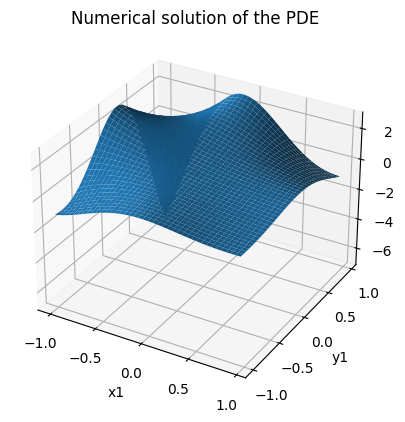

In [417]:
model0=PDESolverLaplace(
        X_int=make_points_inside(4000),
        X_boundary=make_points_boundary(600),
        sigma=sigma,
        name=f'model 0')
model0.setup_fit(f,real_u)
model0.a = np.concatenate(
    [
        model0.g_vec,
        model0.f_vec,
    ]
)
model0.coeff = model0.K_inv @ model0.a
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [416]:
laplace_models[0].laplacian(np.array([[0.1,0.1]]))

array([-1584.27216388])

In [ ]:
print(1/0)

ZeroDivisionError: division by zero

Current residual 3.819e-14: : 2it [00:00, 44.35it/s]
Current residual 1.414e-14: : 2it [00:00, 70.97it/s]
Current residual 2.259e-13: : 2it [00:00, 71.95it/s]
Current residual 4.235e-14: : 2it [00:00, 70.85it/s]


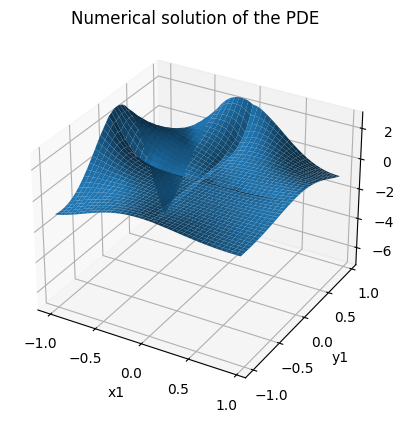

Current residual 6.750e-14: : 2it [00:00, 33.76it/s]
Current residual 1.332e-13: : 2it [00:00, 21.84it/s]
Current residual 3.467e-14: : 2it [00:00, 54.26it/s]
Current residual 2.680e-14: : 2it [00:00, 21.31it/s]


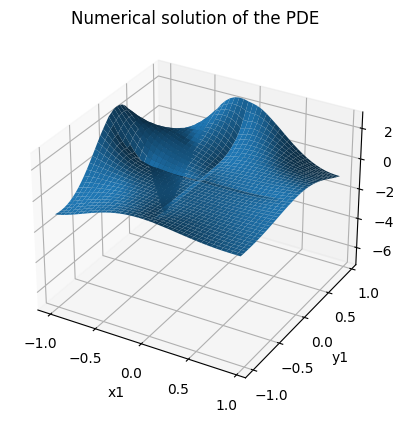

Current residual 3.467e-14: : 2it [00:00, 52.18it/s]
Current residual 2.680e-14: : 2it [00:00, 22.01it/s]
Current residual 6.750e-14: : 2it [00:00, 52.85it/s]
Current residual 1.332e-13: : 2it [00:00, 21.42it/s]


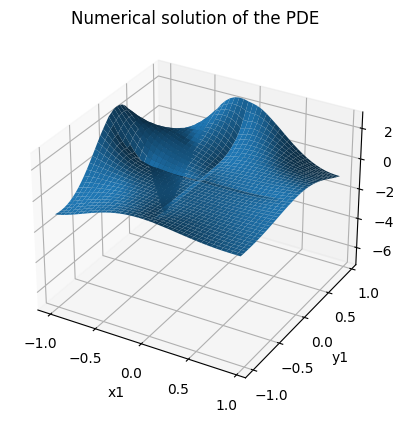

Current residual 2.680e-14: : 2it [00:00, 36.42it/s]
Current residual 1.332e-13: : 2it [00:00, 21.33it/s]
Current residual 6.750e-14: : 2it [00:00, 54.64it/s]
Current residual 3.467e-14: : 2it [00:00, 20.09it/s]


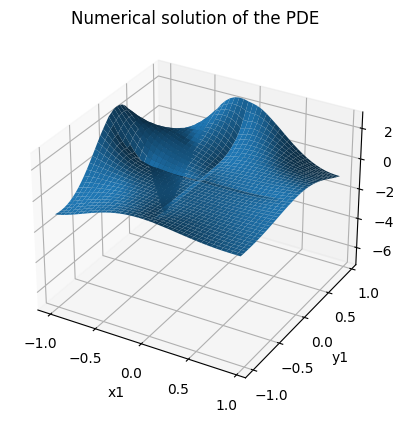

Current residual 2.680e-14: : 2it [00:00, 26.77it/s]
Current residual 1.332e-13: : 2it [00:00, 35.19it/s]
Current residual 3.467e-14: : 2it [00:00, 55.26it/s]
Current residual 6.750e-14: : 2it [00:00, 20.90it/s]


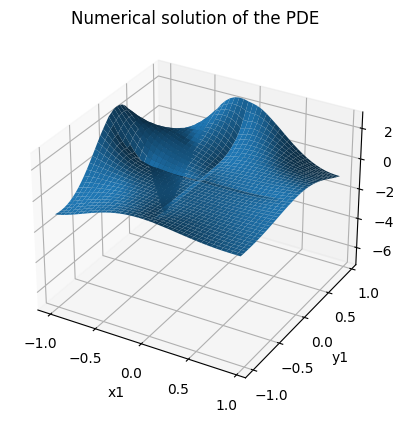

Current residual 2.680e-14: : 2it [00:00, 18.12it/s]
Current residual 3.467e-14: : 2it [00:00, 42.00it/s]
Current residual 6.750e-14: : 2it [00:00, 23.18it/s]
Current residual 1.332e-13: : 2it [00:00, 54.25it/s]


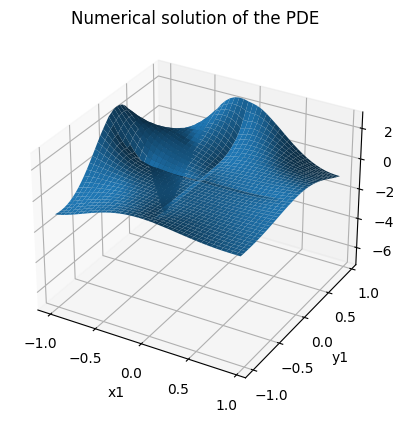

Current residual 6.750e-14: : 2it [00:00, 20.13it/s]
Current residual 1.332e-13: : 2it [00:00, 54.07it/s]
Current residual 3.467e-14: : 2it [00:00, 21.88it/s]
Current residual 2.680e-14: : 2it [00:00, 50.58it/s]


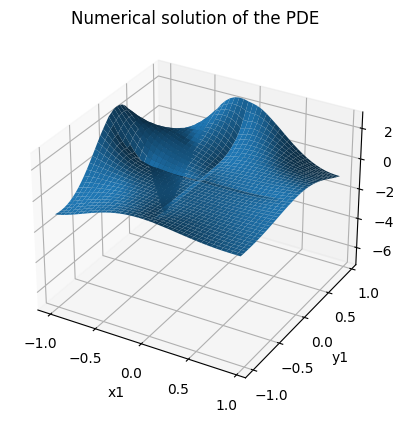

Current residual 3.467e-14: : 2it [00:00, 20.30it/s]
Current residual 2.680e-14: : 2it [00:00, 56.05it/s]
Current residual 6.750e-14: : 2it [00:00, 22.48it/s]
Current residual 1.332e-13: : 2it [00:00, 29.45it/s]


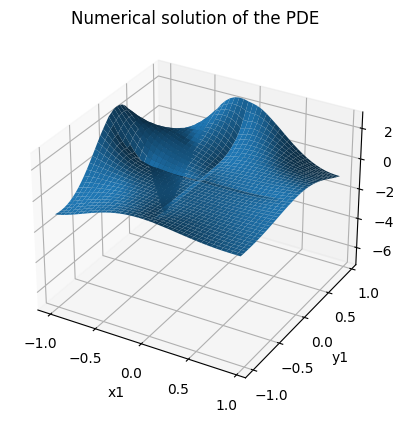

Current residual 1.332e-13: : 2it [00:00, 18.07it/s]
Current residual 2.680e-14: : 2it [00:00, 40.07it/s]
Current residual 3.467e-14: : 2it [00:00, 17.95it/s]
Current residual 6.750e-14: : 2it [00:00, 44.86it/s]


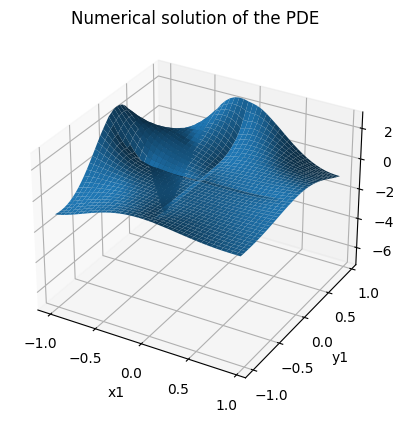

Current residual 2.680e-14: : 2it [00:00, 50.48it/s]
Current residual 3.467e-14: : 2it [00:00, 23.17it/s]
Current residual 1.332e-13: : 2it [00:00, 53.50it/s]
Current residual 6.750e-14: : 2it [00:00, 55.40it/s]


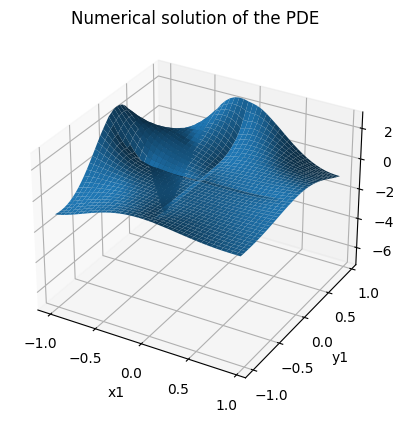

Current residual 1.332e-13: : 2it [00:00, 48.84it/s]
Current residual 6.750e-14: : 2it [00:00, 20.92it/s]
Current residual 2.680e-14: : 2it [00:00, 46.57it/s]
Current residual 3.467e-14: : 2it [00:00, 49.92it/s]


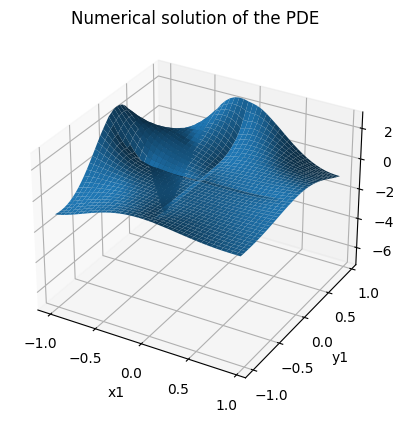

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


In [ ]:
for model in models:
    model.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)
PDESolver.joint_fit_boundaries(models)
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()
for i in tqdm(range(10)):
    indexes=[k for k in range(len(models))]
    shuffle(indexes)
    for j in indexes:
        models[j].fit_interior(f,real_u,tau,dtau,use_shared=True,nugget=1e-5)
    PDESolver.joint_fit_boundaries(models)
    local_aggregate=partial(dumb_aggregate,models=models,width=width)
    fig=plot_vectorized_function(local_aggregate,0.05)
    plt.title('Numerical solution of the PDE')
    plt.show()


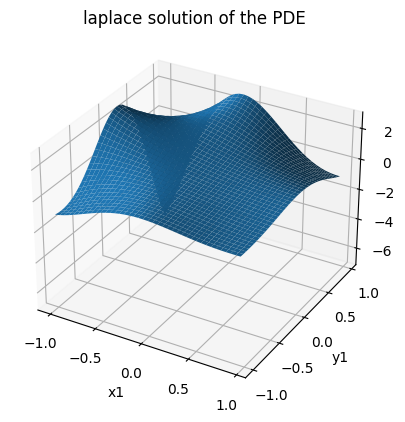

In [ ]:
fig=plot_function(real_u)
plt.title('laplace solution of the PDE')
plt.show()

In [ ]:
'''for model,laplace_clone in zip(models,laplace_models):
    laplace_clone.setup_fit(f, real_u, 1e-5)
    target= np.concatenate(
        [
            model.g_vec,
            model.f_vec,
        ]
    )
    laplace_clone.target_values=target'''
PDESolverLaplace.joint_fit(laplace_models,f,real_u)

{('dirac', model laplace 0, model laplace 1): (0, 1), ('dirac', model laplace 0, model laplace 2): (1, 2), ('dirac', model laplace 1, model laplace 3): (2, 3), ('dirac', model laplace 2, model laplace 3): (3, 4), ('dx', model laplace 0, model laplace 1): (4, 5), ('dx', model laplace 0, model laplace 2): (5, 6), ('dx', model laplace 1, model laplace 3): (6, 7), ('dx', model laplace 2, model laplace 3): (7, 8), ('dy', model laplace 0, model laplace 1): (8, 9), ('dy', model laplace 0, model laplace 2): (9, 10), ('dy', model laplace 1, model laplace 3): (10, 11), ('dy', model laplace 2, model laplace 3): (11, 12)}
model laplace 0
dirac model laplace 1 0 1
(0, 1)
	 dirac model laplace 1 0 1
	 dirac model laplace 2 1 2
dirac model laplace 2 1 2
(1, 2)
	 dirac model laplace 1 0 1
	 dirac model laplace 2 1 2
dx model laplace 1 26 27
(4, 5)
	 dx model laplace 1 26 27
	 dx model laplace 2 27 28
dx model laplace 2 27 28
(5, 6)
	 dx model laplace 1 26 27
	 dx model laplace 2 27 28
dy model laplace

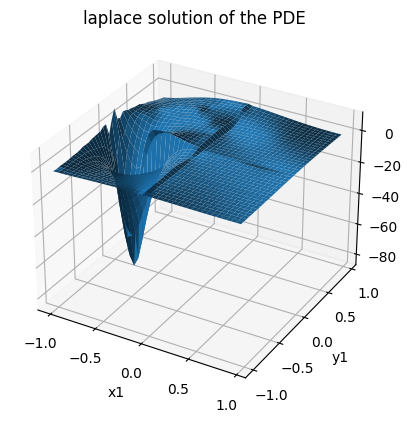

In [ ]:
laplace_aggregate=partial(dumb_aggregate,models=laplace_models,width=width)
fig=plot_vectorized_function(laplace_aggregate,0.05)
plt.title('laplace solution of the PDE')
plt.show()

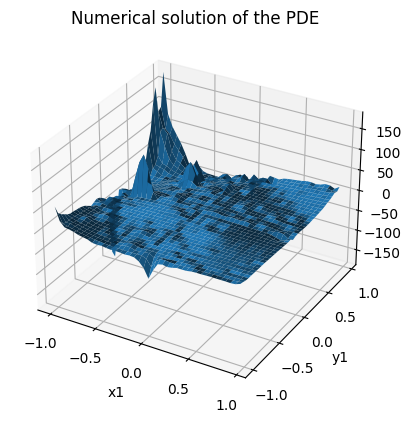

In [ ]:
local_laplacian=partial(laplacian_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_laplacian,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

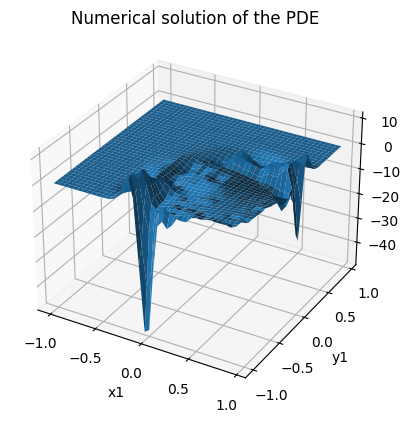

In [ ]:
fig=plot_vectorized_function(models[1].laplacian,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

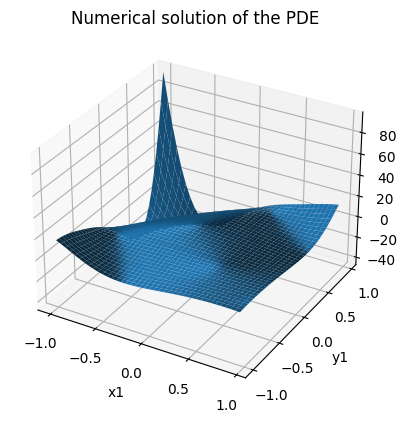

In [ ]:
local_laplacian=partial(laplacian_aggregate,models=models,width=width)
fig=plot_function(lambda x:-f(x)+real_u(x))
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[0].gauss_newton_solution['z']

array([-0.15057639,  0.07107571, -0.90569029, -0.28467013,  0.27106094,
       -0.24345911,  0.03540188,  1.0787649 ,  0.15214664, -0.20989153,
       -0.1988056 ,  0.06990009,  0.25418931, -0.40384216,  0.01513999,
        0.04043139,  0.12954995, -0.02760658, -0.19561378,  0.08176093,
        0.08960846,  0.00977011,  0.33013124, -0.94208997, -0.29663374,
        0.5038297 , -0.34983187,  0.15373221, -0.74604969, -0.51024182,
        1.69090846,  0.16590824, -0.28884663,  0.11033928,  0.01438792,
        0.56380039,  0.71629377, -0.21144616, -0.05209602,  0.30864145,
        1.25523667,  0.26375623, -0.54701591, -0.93350484,  0.20818894,
        0.08164281,  0.06779283,  0.26217054,  1.35049082, -0.96007643,
        0.66421959,  0.10473939,  0.10349285, -0.08291622,  0.90850153,
       -0.8170735 ,  1.37242767, -0.01380416, -0.04118957, -0.03516542,
       -0.25616354,  1.55068858, -0.05093908,  0.12351479,  0.19067091,
        0.29612972,  0.17009223,  0.03887445,  0.06393682,  0.00

In [ ]:
PDESolver.joint_fit_boundaries(models)

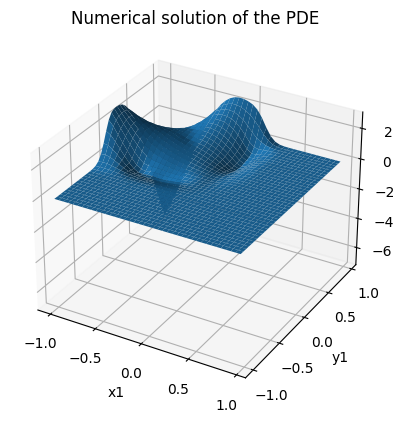

In [ ]:
fig=plot_vectorized_function(models[2],0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[0].shared_value

{model 1: array([-0.01294137]), model 2: array([2.62370429])}

In [ ]:
model0=PDESolver(
        X_int=make_points_inside(1000),
        X_boundary=make_points_boundary(200),
        sigma=sigma,
        name=f'model 0')
model0.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)

Current residual 1.168e-13: : 2it [00:00,  3.98it/s]


In [ ]:

model0.a = np.concatenate(
    [
        model0.gauss_newton_solution["z"],
        model0.g_vec,
        model0.gauss_newton_solution["z_lap"],
    ]
)
model0.coeff = model0.K_inv @ model0.a

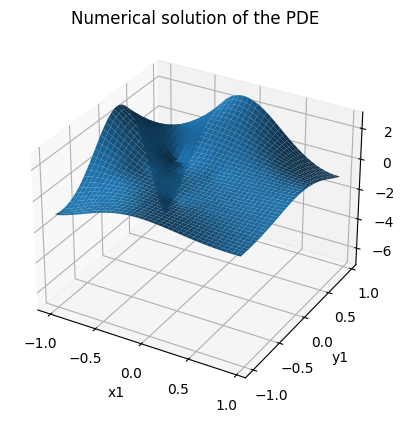

In [ ]:
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()